For this assignmnet I have made use of Titanic dataset from Kaggle: https://www.kaggle.com/c/titanic
The purrpose of this assignmnet is to clean the data and tune a model to predict if people survived or not

In [75]:
#  To mount the data from drive to google collab followed the following documentation: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [76]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from sklearn.preprocessing import MinMaxScaler

In [77]:
downloaded = drive.CreateFile({'id':"1Q_ZkTK0sKrRvRi1uEm3w_u39dmOPhNdO"})
downloaded.GetContentFile('titanic3.xls')

In [78]:
# Dataframe of California_Fire_Incidents
df=pd.read_excel('titanic3.xls')  
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [79]:
# dataframe types: definition of entities in the dataframe
# pclass - Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
# survival - Survival (0 = No, 1 = Yes)
# name - Name
# sex - Sex
# age - Age
# sibsp - Number of siblings/spouses aboard
# parch - Number of parents/children aboard
# ticket - Ticket number
# fare - Passenger fare
# cabin - Cabin
# embarked - Point of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
# boat - Lifeboat
# body - Body identification number
# home.dest - Home/destination
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [80]:
df.shape

(1309, 14)

In [81]:
# count of non-null data
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [82]:
# isnull will define the number of nan values in the dataframe.
# body columns leaks the data while predicting so we can elimate it
# for cabin, boat,body most of the values are null so it can be dropped
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

The body  and boat columns leak weather the passenger has survived the incident.

In [83]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

Features necessary to predict the survival and not-survival
1) From the below plot the percent of female survivors are high in the dataset
This might be because women might be good swimmers

Percentage of females who survived: 72.74678111587983
Percentage of males who survived: 19.098457888493474


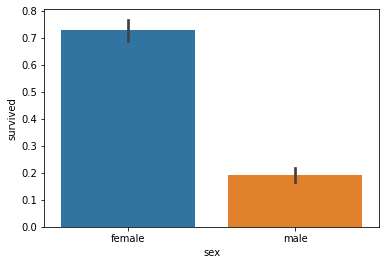

In [84]:
sns.barplot(x="sex", y="survived", data=df)
print("Percentage of females who survived:", df["survived"][df["sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Percentage of males who survived:", df["survived"][df["sex"] == 'male'].value_counts(normalize = True)[1]*100)

First class are the highest surviors.

Percentage of Pclass = 1 who survived: 61.91950464396285
Percentage of Pclass = 2 who survived: 42.96028880866426
Percentage of Pclass = 3 who survived: 25.52891396332863


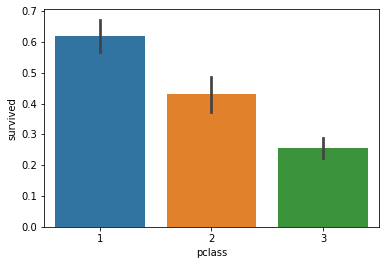

In [85]:
sns.barplot(x="pclass", y="survived", data=df)
print("Percentage of Pclass = 1 who survived:", df["survived"][df["pclass"] == 1].value_counts(normalize = True)[1]*100)
print("Percentage of Pclass = 2 who survived:", df["survived"][df["pclass"] == 2].value_counts(normalize = True)[1]*100)
print("Percentage of Pclass = 3 who survived:", df["survived"][df["pclass"] == 3].value_counts(normalize = True)[1]*100)

Cleaning age category if it would help predict if the person survived or not

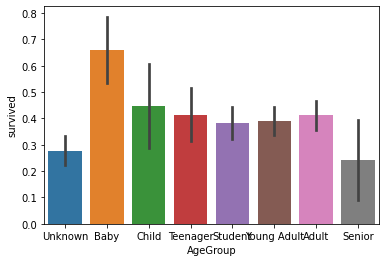

In [86]:
df["age"] = df["age"].fillna(-0.5)
df["age"] = df["age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df["age"], bins, labels = labels)
df['AgeGroup'] = pd.cut(df["age"], bins, labels = labels)
sns.barplot(x="AgeGroup", y="survived", data=df)
plt.show()

Age is a important factor as it is distributed with high missing values

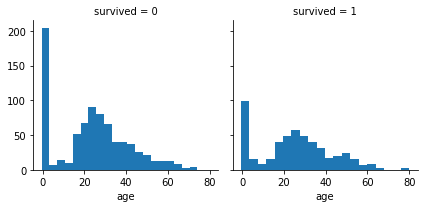

In [103]:
g = sns.FacetGrid(df, col='survived')
g.map(plt.hist, 'age', bins=20)

To predict if the passenger has survived the incident or not these features are not necessary.
To indetify if the features are necessary, I am using coreraltion matrix.
If the number is equal to 1 then the cateory is highly co-related

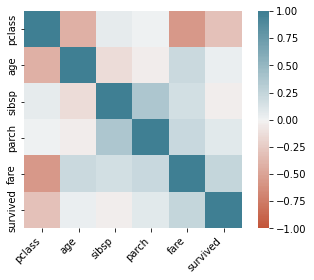

In [102]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [87]:
df=df.drop(columns=["name", "ticket", "home.dest", "boat", "body", "cabin"])

In [88]:
# creating dummy columns based on the column object values
df = pd.get_dummies(df)

In [89]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'AgeGroup_Unknown', 'AgeGroup_Baby', 'AgeGroup_Child',
       'AgeGroup_Teenager', 'AgeGroup_Student', 'AgeGroup_Young Adult',
       'AgeGroup_Adult', 'AgeGroup_Senior'],
      dtype='object')

In [90]:
# the sex columns are highly correlated it is binary and can be defined in a single row
df = df.drop(columns="sex_male")
df

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S,AgeGroup_Unknown,AgeGroup_Baby,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior
0,1,1,29.0000,0,0,211.3375,1,0,0,1,0,0,0,0,0,1,0,0
1,1,1,0.9167,1,2,151.5500,0,0,0,1,0,1,0,0,0,0,0,0
2,1,0,2.0000,1,2,151.5500,1,0,0,1,0,1,0,0,0,0,0,0
3,1,0,30.0000,1,2,151.5500,0,0,0,1,0,0,0,0,0,1,0,0
4,1,0,25.0000,1,2,151.5500,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,14.5000,1,0,14.4542,1,1,0,0,0,0,0,1,0,0,0,0
1305,3,0,-0.5000,1,0,14.4542,1,1,0,0,1,0,0,0,0,0,0,0
1306,3,0,26.5000,0,0,7.2250,0,1,0,0,0,0,0,0,0,1,0,0
1307,3,0,27.0000,0,0,7.2250,0,1,0,0,0,0,0,0,0,1,0,0


In [91]:
num_cols=["pclass", "age", "sibsp", "parch", "fare", "survived"]
df=pd.DataFrame(df, columns=num_cols)
y = df.survived
X = df.drop(columns="survived")

# Split the data into train and test set

In [92]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


# Normalize the Data
After normalizing the data the model performs better

In [93]:
sca = StandardScaler()
X_train = sca.fit_transform(X_train)
X_test = sca.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train=X_train.replace(np.nan, 0)
X_test=X_test.replace(np.nan, 0)

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

In [95]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
for model in [
              LogisticRegression,
              DecisionTreeClassifier, 
              KNeighborsClassifier,
              GaussianNB, 
              SVC, 
              RandomForestClassifier, 
              xgboost.XGBClassifier]:

              cls=model()
              kfold=model_selection.KFold(n_splits=10, random_state=42)
              s=model_selection.cross_val_score(cls, X, y, scoring='roc_auc', cv=kfold)
              print(
                f"{model.__name__:22}  AUC: "
                f"{s.mean():.3f} STD: {s.std():.2f}"
              )

LogisticRegression      AUC: 0.702 STD: 0.03
DecisionTreeClassifier  AUC: 0.627 STD: 0.04
KNeighborsClassifier    AUC: 0.717 STD: 0.03
GaussianNB              AUC: 0.663 STD: 0.05
SVC                     AUC: 0.710 STD: 0.03
RandomForestClassifier  AUC: 0.724 STD: 0.04
XGBClassifier           AUC: 0.751 STD: 0.02


From the above model we can see that both the RandomForestClassifier and XGBClassifier has high AUC score. To predict my model who survived or not I will make use of RandomForestClassifier with AUC: 0.718 STD: 0.04

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [97]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [98]:
clf.score(X_test, y_test)

0.6643518518518519

In [99]:
metrics.precision_score(y_test, clf.predict(X_test))

0.726027397260274

In [100]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[234,  20],
       [125,  53]])